In [2]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import community
import numpy as np
from networkx.algorithms import cuts
import pandas as pd

In [3]:
G = nx.karate_club_graph()

In [4]:
girvan_newman_generator = community.girvan_newman(G)
girvan_newman_partition = max(girvan_newman_generator, 
                              key=lambda partition: community.modularity(G, partition))

In [5]:
label_propagation_partition = community.label_propagation_communities(G)
louvain_partition = list(community.louvain_communities(G))

In [6]:
def calculate_metrics(G, communities):
    metrics = {
        'num_communities': len(communities),
        'modularity': community.modularity(G, communities),
        'conductance': np.mean([cuts.conductance(G, c) for c in communities]),
        'normalized_cut': np.mean([cuts.normalized_cut_size(G, c) for c in communities])
    }
    return metrics

In [7]:
def create_community_node_colors(graph, communities):
    node_colors = []
    for node in graph:
        for idx, comm in enumerate(communities):
            if node in comm:
                node_colors.append(plt.cm.jet(idx / len(communities)))
                break
    return node_colors

def visualize_communities(graph, communities, title, ax):
    node_colors = create_community_node_colors(graph, communities)
    pos = nx.spring_layout(graph, k=0.3, iterations=50, seed=2)
    modularity = community.modularity(graph, communities)

    ax.set_title(f"{title}\n{len(communities)} communities (Modularity: {modularity:.3f})")
    nx.draw(graph, pos=pos, node_size=500, node_color=node_colors,
            with_labels=True, font_size=10, ax=ax)

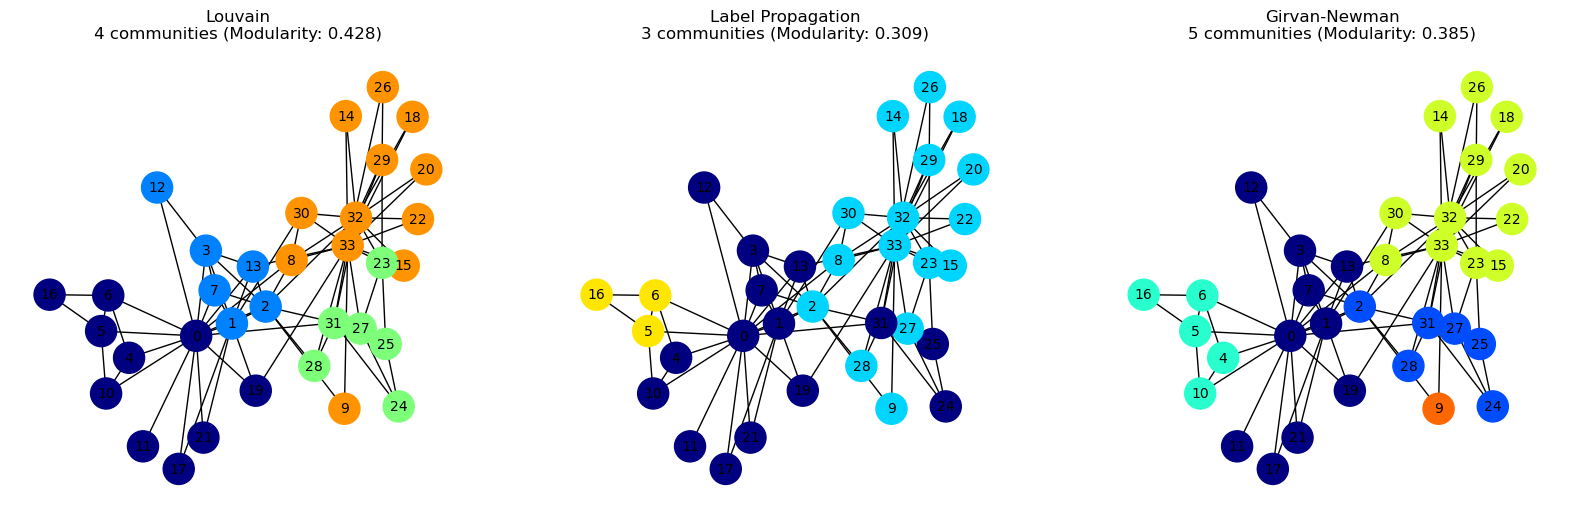

In [8]:
# Plot communities
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

visualize_communities(G, louvain_partition, "Louvain", axes[0])
visualize_communities(G, label_propagation_partition, "Label Propagation", axes[1])
visualize_communities(G, girvan_newman_partition, "Girvan-Newman", axes[2])

In [9]:
# Create DataFrame for metrics comparison
metrics_data = []
algorithms = ["Louvain", "Label Propagation", "Girvan-Newman"]
def visualize_metrics():
    for partition, algorithm in zip([louvain_partition, label_propagation_partition, girvan_newman_partition], algorithms):
        metrics = calculate_metrics(G, partition)
        metrics_data.append({
            'Algorithm': algorithm,
            'Num Communities': metrics['num_communities'],
            'Modularity': metrics['modularity'],
            'Conductance': metrics['conductance'],
            'Normalized Cut': metrics['normalized_cut']
        })

    metrics_df = pd.DataFrame(metrics_data)

    # Plot the comparison of metrics
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))

    # Bar chart for comparing 'Num Communities' between algorithms
    axes[0].bar(metrics_df['Algorithm'], metrics_df['Num Communities'], color="#8E44AD")
    axes[0].set_title("Num Communities Comparison")
    axes[0].set_xlabel("Algorithm")
    axes[0].set_ylabel("Num Communities")

    # Bar chart for comparing Modularity, Conductance, and Normalized Cut for each algorithm
    bar_width = 0.6  # Increase the width of the bars
    x = np.arange(len(metrics_df['Algorithm']))  # X positions for each algorithm

    axes[1].bar(x - bar_width/2, metrics_df['Modularity'], width=bar_width, label='Modularity', color="#F2D140")
    axes[1].bar(x - bar_width/2, metrics_df['Conductance'], width=bar_width, label='Conductance', color="#FF6347", bottom=metrics_df['Modularity'])
    axes[1].bar(x - bar_width/2, metrics_df['Normalized Cut'], width=bar_width, label='Normalized Cut', color="#48C9B0", bottom=metrics_df['Modularity'] + metrics_df['Conductance'])

    axes[1].set_title("Comparison of Metrics")
    axes[1].set_xlabel("Algorithm")
    axes[1].set_ylabel("Value")
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(metrics_df['Algorithm'])
    axes[1].legend()

    plt.tight_layout()
    plt.show()

In [10]:
class CommunityGraph(nx.Graph):
    def __init__(self, graph):
        self.graph = graph
        self.partitions = {}
        self.metrics = pd.DataFrame()
    
    def detect_girvan_newman(self):
        generator = community.girvan_newman(self.graph)
        best_partition = max(generator, key=lambda partition: community.modularity(self.graph, partition))
        self.partitions['Girvan-Newman'] = list(best_partition)

    def detect_label_propagation(self):
        partition = list(community.label_propagation_communities(self.graph))
        self.partitions['Label Propagation'] = partition

    def detect_louvain(self):
        partition = list(community.louvain_communities(self.graph))
        self.partitions['Louvain'] = partition

    def calculate_metrics(self):
        metrics_data = []
        for name, communities in self.partitions.items():
            metrics_data.append({
                'Algorithm': name,
                'Num Communities': len(communities),
                'Modularity': community.modularity(self.graph, communities),
            })
        self.metrics = pd.DataFrame(metrics_data)

    def create_community_node_colors(self, communities):
        node_colors = []
        for node in self.graph:
            for idx, comm in enumerate(communities):
                if node in comm:
                    node_colors.append(plt.cm.jet(idx / len(communities)))
                    break
        return node_colors

    def visualize_communities(self):
        fig, axes = plt.subplots(1, len(self.partitions), figsize=(20, 6))
        for ax, (name, communities) in zip(axes, self.partitions.items()):
            node_colors = self.create_community_node_colors(communities)
            pos = nx.spring_layout(self.graph, k=0.3, iterations=50, seed=2)
            modularity_score = community.modularity(self.graph, communities)
            ax.set_title(f"{name}\n{len(communities)} communities (Modularity: {modularity_score:.3f})")
            nx.draw(self.graph, pos=pos, node_size=500, node_color=node_colors,
                    with_labels=True, font_size=10, ax=ax)
        plt.tight_layout()
        plt.show()

    def plot_metrics(self):
        if self.metrics.empty:
            print("Metrics have not been calculated yet.")
            return

        fig, axes = plt.subplots(1, 2, figsize=(18, 7))

        # Bar chart for comparing 'Num Communities'
        axes[0].bar(self.metrics['Algorithm'], self.metrics['Num Communities'], color="#8E44AD")
        axes[0].set_title("Num Communities Comparison")
        axes[0].set_xlabel("Algorithm")
        axes[0].set_ylabel("Num Communities")

        # Bar chart for comparing Modularity
        axes[1].bar(self.metrics['Algorithm'], self.metrics['Modularity'], color="#F2D140")
        axes[1].set_title("Modularity Comparison")
        axes[1].set_xlabel("Algorithm")
        axes[1].set_ylabel("Modularity")

        plt.tight_layout()
        plt.show()

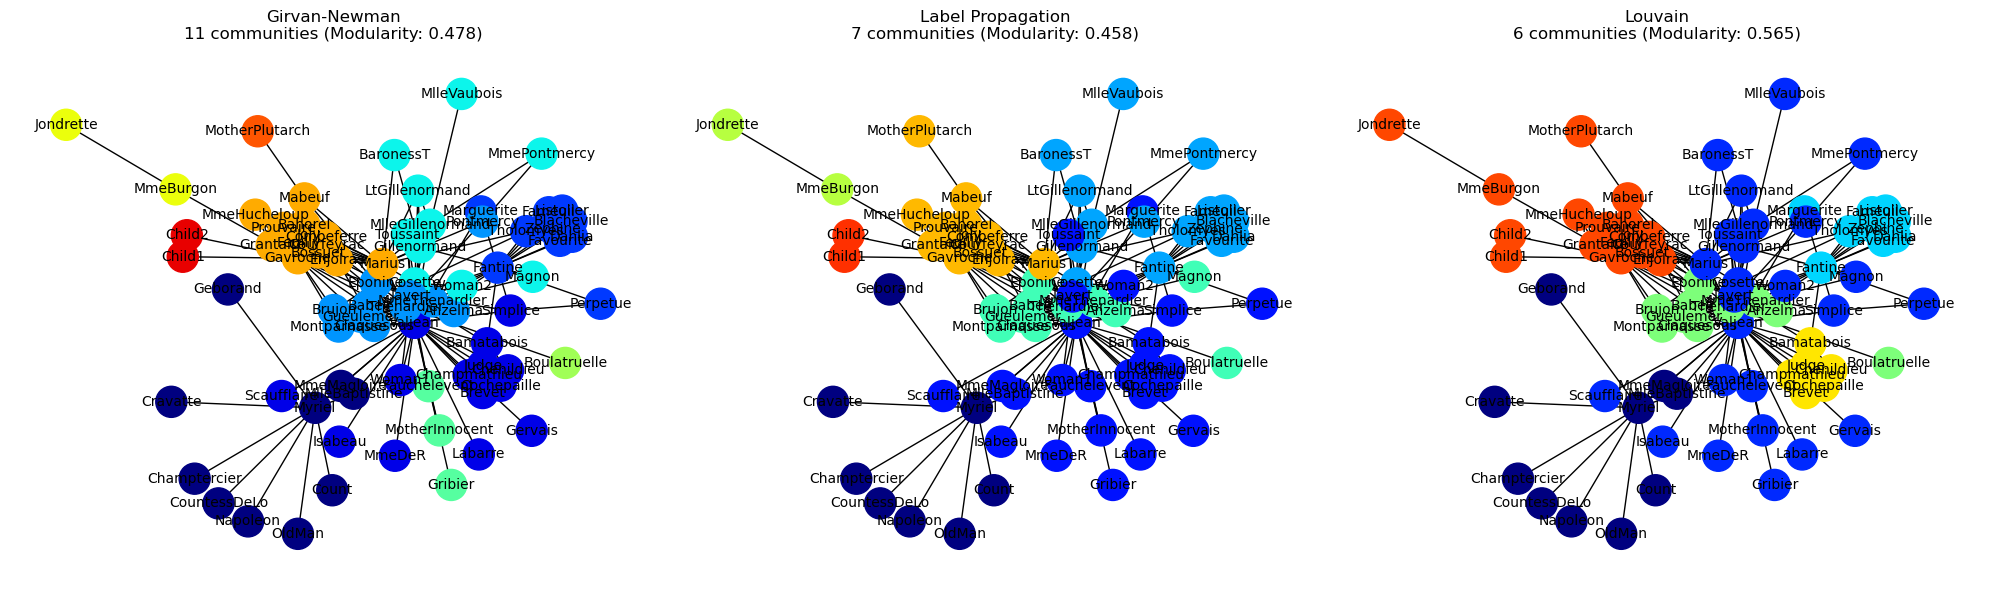

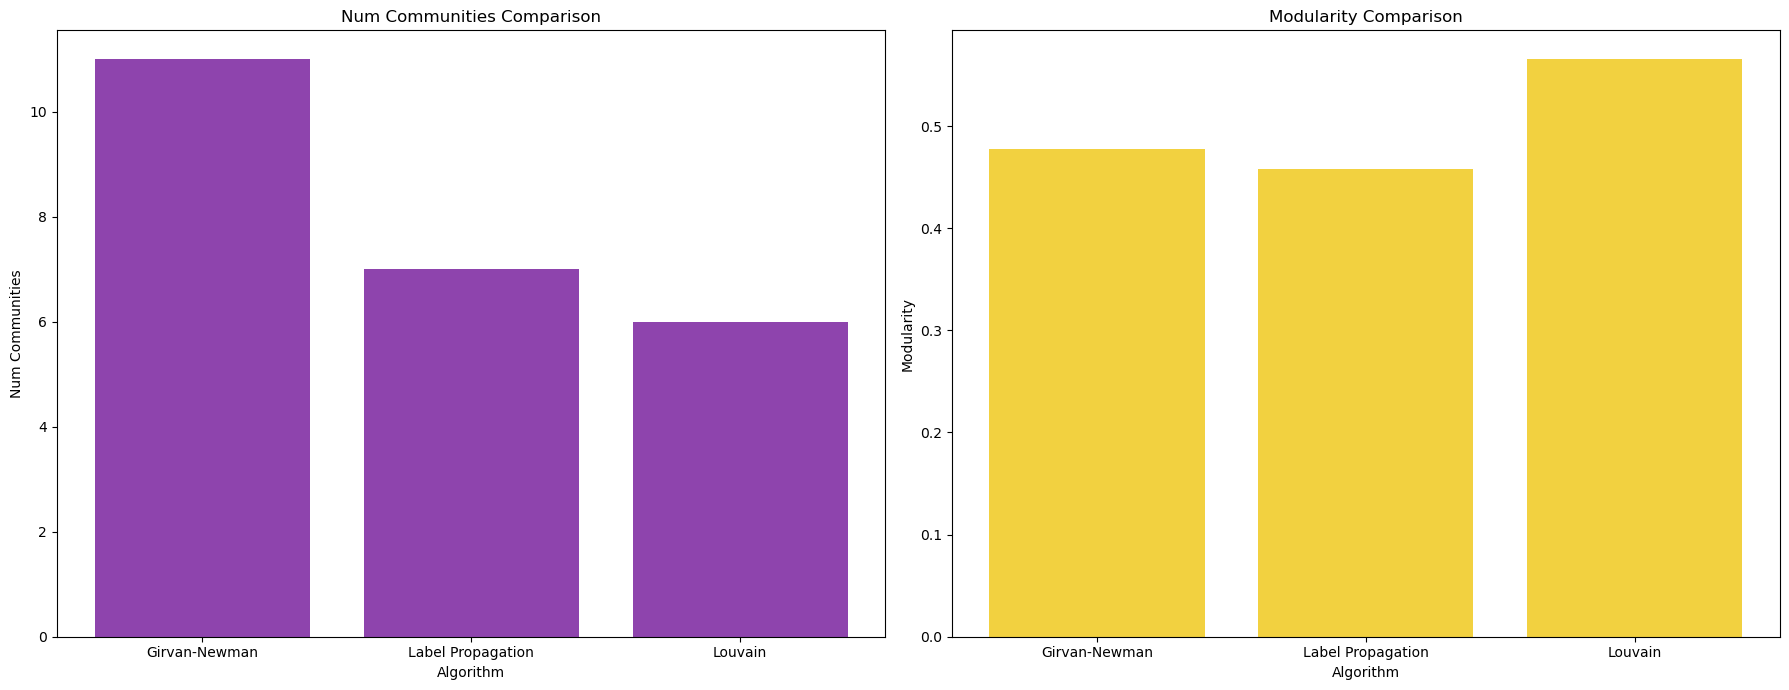

In [11]:
G = nx.les_miserables_graph()
detector = CommunityGraph(G)
detector.detect_girvan_newman()
detector.detect_label_propagation()
detector.detect_louvain()
detector.calculate_metrics()
detector.visualize_communities()
detector.plot_metrics()